In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pystan

In [2]:
N = 10000
p_true = 0.6789  # arbitrary choice
y = np.random.binomial(1, p_true, size=N)
data = {'N': N, 'y': y}

In [3]:
pystan.stan_rdump(data, 'data.R')

In [4]:
code = '''
data {
    int<lower=0> N;
    int<lower=0,upper=1> y[N];
}
parameters {
    real<lower=0,upper=1> p;
}
model {
    p ~ beta(1,1);
    y ~ bernoulli(p);
}
'''
with open('model.stan', 'w') as f:
    f.write(code)

In [5]:
%%bash
cd cmdstan
make ../model


--- Translating Stan model to C++ code ---
bin/stanc ../model.stan --o=../model.hpp
Model name=model_model
Input file=../model.stan
Output file=../model.hpp

--- Linking C++ model ---
g++ -I src -I stan/src -isystem stan/lib/stan_math/ -isystem stan/lib/stan_math/lib/eigen_3.2.8 -isystem stan/lib/stan_math/lib/boost_1.60.0 -isystem stan/lib/stan_math/lib/cvodes_2.8.2/include -Wall -DEIGEN_NO_DEBUG  -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DFUSION_MAX_VECTOR_SIZE=12 -DNO_FPRINTF_OUTPUT -pipe  -Wno-unused-function -ftemplate-depth-256    -O3 -o ../model src/cmdstan/main.cpp -include ../model.hpp stan/lib/stan_math/lib/cvodes_2.8.2/lib/libsundials_nvecserial.a stan/lib/stan_math/lib/cvodes_2.8.2/lib/libsundials_cvodes.a 


# NUTS

In [6]:
%%bash
rm nuts*.output.csv
for i in `seq 9`; do
    ./model \
        sample \
        data file=data.R \
        output file=nuts$i.output.csv;
done;

method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta = 0.80000000000000004 (Default)
      kappa = 0.75 (Default)
      t0 = 10 (Default)
      init_buffer = 75 (Default)
      term_buffer = 50 (Default)
      window = 25 (Default)
    algorithm = hmc (Default)
      hmc
        engine = nuts (Default)
          nuts
            max_depth = 10 (Default)
        metric = diag_e (Default)
        stepsize = 1 (Default)
        stepsize_jitter = 0 (Default)
id = 0 (Default)
data
  file = data.R
init = 2 (Default)
random
  seed = 2083366517
output
  file = nuts1.output.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)


Gradient evaluation took 0.000105 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.05 seconds.
Adjust your expectations accordingly!


Iterati

In [7]:
nuts_csvs = ['nuts' + str(i+1) + '.output.csv' for i in range(9)]
nuts_fits = [pd.read_csv(f, comment='#') for f in nuts_csvs]

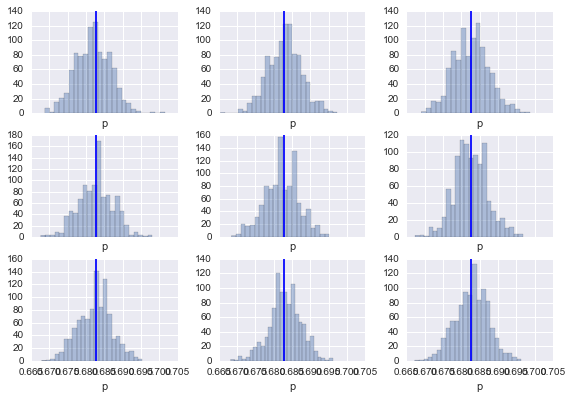

In [8]:
fig, ax = plt.subplots(3, 3, sharex=True)
fig.tight_layout()

for p, a in zip(nuts_fits, ax.ravel()):
    a = sns.distplot(p['p'], kde=False, ax=a)
    a.axvline(y.mean())

# ADVI

In [9]:
%%bash
rm variational*.output.csv
for i in `seq 9`; do
    ./model \
        variational \
        data file=data.R \
        output file=variational$i.output.csv;
done;

method = variational
  variational
    algorithm = meanfield (Default)
      meanfield
    iter = 10000 (Default)
    grad_samples = 1 (Default)
    elbo_samples = 100 (Default)
    eta = 1 (Default)
    adapt
      engaged = 1 (Default)
      iter = 50 (Default)
    tol_rel_obj = 0.01 (Default)
    eval_elbo = 100 (Default)
    output_samples = 1000 (Default)
id = 0 (Default)
data
  file = data.R
init = 2 (Default)
random
  seed = 2083374615
output
  file = variational1.output.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)


This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.000118 seconds
1000 iterations under these settings should take 0.118 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adap

In [10]:
variational_csvs = ['variational' + str(i+1) + '.output.csv' for i in range(9)]
variational_fits = [pd.read_csv(f, comment='#') for f in variational_csvs]

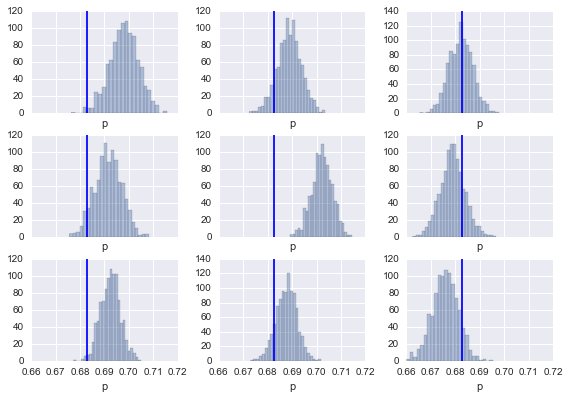

In [11]:
fig, ax = plt.subplots(3, 3, sharex=True)
fig.tight_layout()

for p, a in zip(variational_fits, ax.ravel()):
    a = sns.distplot(p['p'], kde=False, ax=a)
    a.axvline(y.mean())